In [1]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from skimage.segmentation import slic
import skimage as ski

from multiprocessing import Pool

from sklearn.metrics import f1_score, accuracy_score

In [21]:
import mnist_slic
import model

Example for visualization

In [2]:
ds = datasets.FashionMNIST(root = "./fashion_mnist/test", train=False, download=True, transform=T.ToTensor())
len(ds)

10000

In [3]:
from compute_features import grayscale_features

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12


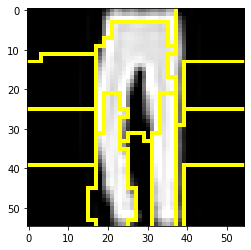

In [4]:
img, y = ds[2]
_, dim0, dim1 = img.shape
img_np = img.view(dim0, dim1).numpy()
n_segments = 20
compactness = 0.1
s, features = grayscale_features(img_np, n_segments, compactness)
# s = slic(img_np, n_segments, compactness)
print(len(np.unique(s)))
plt.imshow(ski.segmentation.mark_boundaries(img_np, s, mode='subpixel'))

In [12]:
features[0,:]/255

array([0.22021475, 0.37558958, 0.00840336, 0.02745098, 0.00692959,
       0.02067143, 0.32941176])

In [3]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import StratifiedKFold

In [20]:
ds = ConcatDataset([ds_train, ds_test])
y = torch.cat([ds_train.targets, ds_test.targets])
print(ds[idx][1], y[idx])

3 tensor(3)


In [11]:
skf = StratifiedKFold(n_splits=5)
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [53]:
n_segments = 10
compactness = 0.1

# features 
get_avg_color = True
get_std_deviation_color = True
get_centroid = True
get_std_deviation_centroid = True
get_num_pixels = True
get_avg_color_distance = False
get_std_dev_color_distance = False

feature_mask = np.array([True, True, True, True, True, True, False])

In [56]:
img, y = ds[0]
_, dim0, dim1 = img.shape
img_np = img.view(dim0, dim1).numpy()
s, features, edges = grayscale_features(img_np, n_segments, compactness)
print(len(np.unique(s)))
x = features.T[feature_mask]
print(x.shape)

5
(5, 5)


In [55]:
x.shape

(5, 5)

In [16]:
# same as function used in SuperPixelGraphMNIST
img, y = ds[1]
_, dim0, dim1 = img.shape
img_np = img.view(dim0, dim1).numpy()
s, features, edges = grayscale_features(img_np, n_segments, compactness)
g = ski.future.graph.rag_mean_color(img_np, s)
n = g.number_of_nodes()
s1 = np.zeros([n, 1])  # for mean color and std deviation
s2 = np.zeros([n, 1])  # for std deviation
pos1 = np.zeros([n, 2]) # for centroid
pos2 = np.zeros([n, 2]) # for centroid std deviation
num_pixels = np.zeros([n, 1])
for idx in range(dim0 * dim1):
        idx_i, idx_j = idx % dim0, int(idx / dim0)
        node = s[idx_i][idx_j] - 1
        s1[node][0]  += img_np[idx_i][idx_j]
        s2[node][0]  += pow(img_np[idx_i][idx_j], 2)
        pos1[node][0] += idx_i
        pos1[node][1] += idx_j
        pos2[node][0] += pow(idx_i, 2)
        pos2[node][1] += pow(idx_j, 2)
        num_pixels[node][0] += 1

In [36]:
# computing features
edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
x = []
s1 = s1/num_pixels
avg_color = s1
if get_avg_color:
    x.append(torch.from_numpy(avg_color.flatten()).to(torch.float))
s2 = s2/num_pixels
std_deviation = np.sqrt(s2 - s1*s1)
if get_std_deviation_color:
    x.append(torch.from_numpy(std_deviation.flatten()).to(torch.float))
pos1 = pos1/num_pixels
pos = torch.from_numpy(pos1).to(torch.float)
if get_centroid:
    x.append(pos[:,0])
    x.append(pos[:,1])
if get_std_deviation_centroid:
    pos2 = pos2/num_pixels
    std_deviation_centroid = torch.from_numpy(np.abs(np.sqrt(pos2 - pos1*pos1))).to(torch.float)
    x.append(std_deviation_centroid[:,0])
    x.append(std_deviation_centroid[:,1])
if get_num_pixels:
    x.append(torch.from_numpy(num_pixels.flatten()).to(torch.float))
if get_avg_color_distance or get_std_dev_color_distance:
    distances = [[g.edges[u,v]['weight'] for u, v in g.edges(node_idx)] for node_idx in range(n)]
    if get_avg_color_distance:
        x.append(torch.Tensor([np.average(distance) for distance in distances]))
    if get_std_dev_color_distance:
        x.append(torch.Tensor([np.std(distance) for distance in distances]))
data = Data(x=torch.stack(x, dim=1), edge_index=edge_index, pos=pos, y=y)

In [38]:
print( len(x))
print(features.T.shape)

7
(7, 5)


In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y}')
color_feature = 0
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=data.x[:,color_feature])

In [23]:
spds = mnist_slic.SuperPixelGraphMNIST(root='test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance')

Processing...


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw/train-images-idx3-ubyte.gz to test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw/train-labels-idx1-ubyte.gz to test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw/t10k-images-idx3-ubyte.gz to test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw/t10k-labels-idx1-ubyte.gz to test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance/MNIST/raw



KeyboardInterrupt: 

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
data = spds[3]

g = to_networkx(data, to_undirected=True)
print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y[0]}')
color_feature = 4
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=data.x[:,color_feature])
# acho que ta virado ?

In [ ]:
data.num_node_features